# hw2: Решающие деревья

*Спасибо великому курсу великого Евгения Соколова*

### О задании

Задание состоит из двух разделов:
1. В первом разделе вы научитесь применять деревья из sklearn для задачи классификации. Вы посмотрите какие разделяющие поверхности деревья строят для различных датасетов и проанализируете их зависимость от различных гиперпараметров.
2. Во втором разделе вы попробуете реализовать свое решающее дерево и сравните его со стандартное имплементацией из sklearn. Вы также протестируете деревья на более сложных датасетах и сравните различные подходы к кодированию категориальных признаков.

Все данные, на которых будут обучаться модели, вы можете найти на диске.

### Оценивание и штрафы
Каждая из задач имеет определенную «стоимость» (указана в скобках около задачи). Максимально допустимая оценка за работу — 10 баллов. Неэффективная и/или неоригинальная реализация кода может негативно отразиться на оценке.

### Формат сдачи
Заполненный ноутбук ```hw2-trees.ipynb``` и модуль с реализованными функциями и классами ```hw2code.py``` необходимо загрузить на свой Github. Затем нужно оставить комментарий в Google-таблице с оценками в столбце <<hw2>> в строке со своей фамилией о том, что вы выполнили работу с указанием ника на Kaggle.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from matplotlib.colors import Colormap, ListedColormap
import pandas as pd
from sklearn.model_selection import train_test_split
import seaborn as sns
sns.set(style='whitegrid')

import warnings
warnings.filterwarnings('ignore')

# 1. Решающие деревья. Визуализация.

В этой части мы рассмотрим два простых двумерных датасета сделанных с помощью `make_moons`, `make_circles` и посмотрим как ведет себя разделяющая поверхность в зависимости от различных гиперпараметров.

In [2]:
from sklearn.datasets import make_moons, make_circles, make_classification
datasets = [
    make_circles(noise=0.2, factor=0.5, random_state=42),
    make_moons(noise=0.2, random_state=42),
    make_classification(n_classes=3, n_clusters_per_class=1, n_features=2, class_sep=.8, random_state=3,
                        n_redundant=0, )
]
dnames = ["Circles", "Moons", "Classification"]

In [3]:
palette = sns.color_palette(n_colors=3)
cmap = ListedColormap(palette)

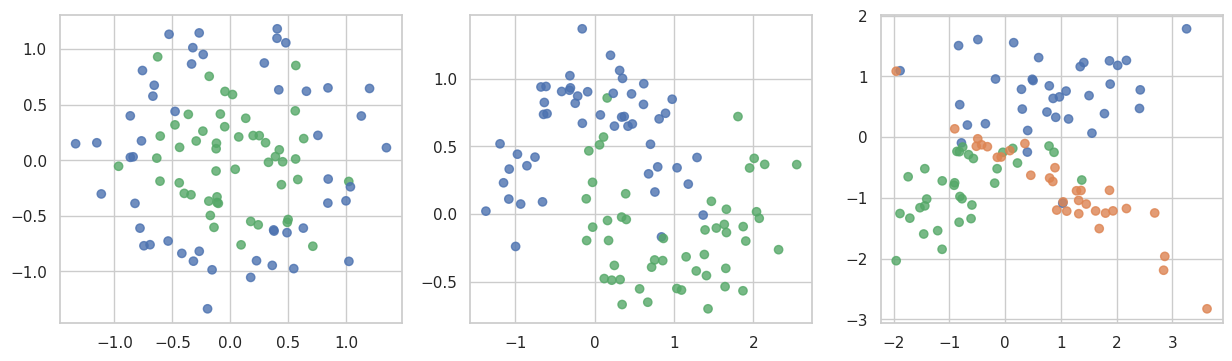

In [4]:
plt.figure(figsize=(15, 4))
for i, (x, y) in enumerate(datasets):
    plt.subplot(1, 3, i + 1)
    plt.scatter(x[:, 0], x[:, 1], c=y, cmap=cmap, alpha=.8)

__Задание 1. (1 балл)__

    Для каждого датасета обучите решающее дерево с параметрами по умолчанию, предварительно разбив выборку на обучающую и тестовую. Постройте разделящие поверхности (для этого воспользуйтесь функцией `plot_surface`, пример ниже). Посчитайте accuracy на обучающей и тестовой выборках. Сильно ли деревья переобучились?

In [5]:
def plot_surface(clf, X, y):
    plot_step = 0.01
    palette = sns.color_palette(n_colors=len(np.unique(y)))
    cmap = ListedColormap(palette)
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, plot_step),
                         np.arange(y_min, y_max, plot_step))
    plt.tight_layout(h_pad=0.5, w_pad=0.5, pad=2.5)

    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    cs = plt.contourf(xx, yy, Z, cmap=cmap, alpha=0.3)

    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=cmap, alpha=.7,
                edgecolors=np.array(palette)[y], linewidths=2)

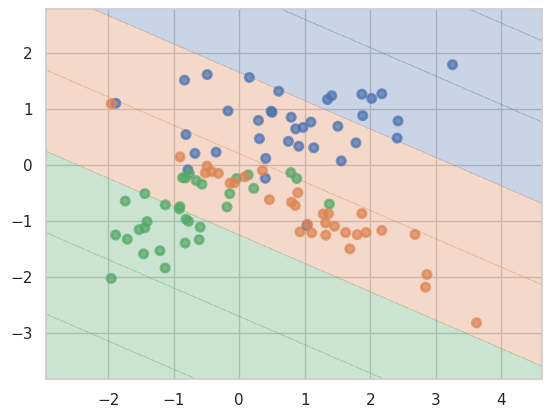

In [6]:
# Пример:
from sklearn.linear_model import LinearRegression
X, y = datasets[2]
lr  = LinearRegression().fit(X, y)
plot_surface(lr, X, y)

Circles
Train accuracy: 1.0
Test accuracy: 0.8484848484848485



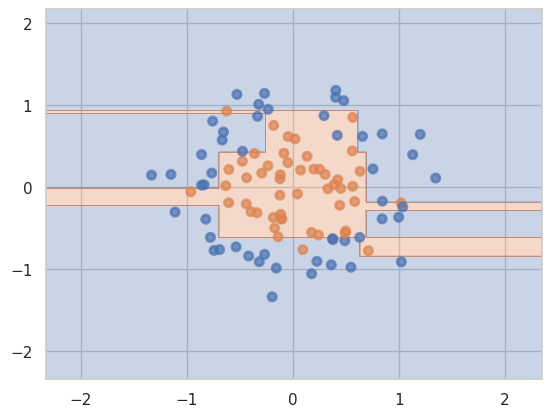

Moons
Train accuracy: 1.0
Test accuracy: 0.9696969696969697



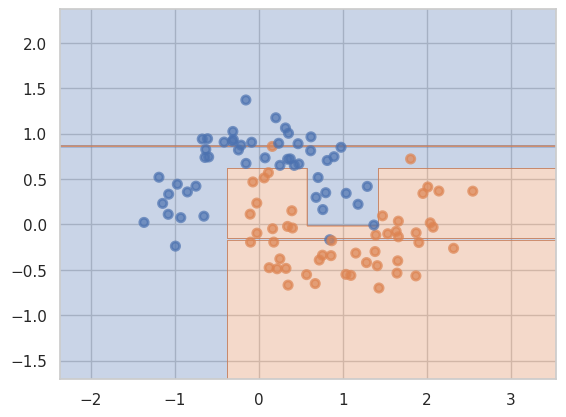

Classification
Train accuracy: 1.0
Test accuracy: 0.8181818181818182



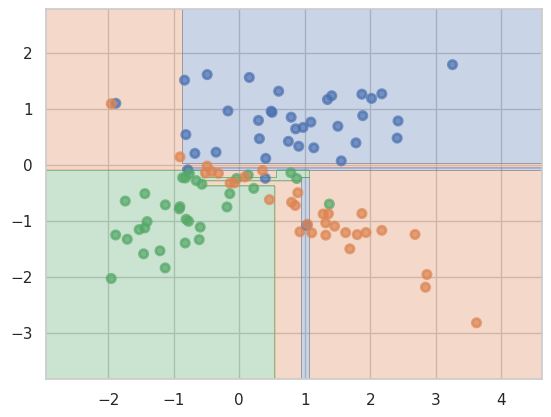

In [7]:
### ╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ
from sklearn.metrics import accuracy_score
for i in range(3):
  X, y = datasets[i]
  S = train_test_split(X, y, test_size=0.33, random_state=9)
  Train, Test = [S[0], S[2]], [S[1], S[3]]
  clf = DecisionTreeClassifier()
  clf.fit(*Train)
  train_acc = accuracy_score(Train[1], clf.predict(Train[0]))
  test_acc = accuracy_score(Test[1], clf.predict(Test[0]))
  print(dnames[i])
  print(f'Train accuracy: {train_acc}')
  print(f'Test accuracy: {test_acc}')
  print()
  plot_surface(clf, X, y)
  plt.show()

__Ответ:__ Train accuracy = 1.0 говорит об сильном переобучении



__Задание 2. (1.5 балла)__

Попробуйте перебрать несколько параметров для регуляризации (напр. `max_depth`, `min_samples_leaf`). Для каждого набора гиперпараметров постройте разделяющую поверхность, выведите обучающую и тестовую ошибки. Можно делать кросс-валидацию или просто разбиение на трейн и тест, главное делайте каждый раз одинаковое разбиение, чтобы можно было корректно сравнивать (помните же, что итоговое дерево сильно зависит от небольшого изменения обучающей выборки?). Проследите как меняется разделяющая поверхность и обобщающая способность. Почему так происходит, одинаково ли изменение для разных датасетов?

Circles
----------
max_depth = None
min_leaf_samples = 3
Train accuracy: 0.9402985074626866
Test accuracy: 0.9090909090909091



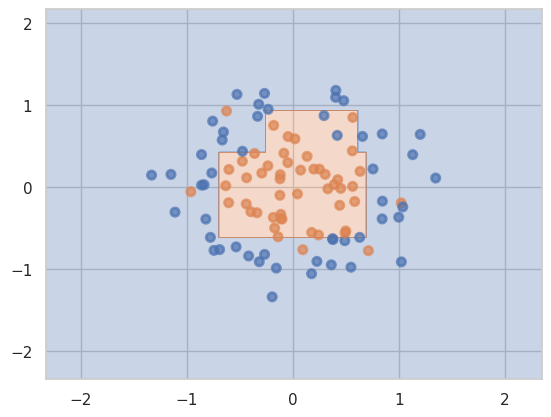

max_depth = None
min_leaf_samples = 5
Train accuracy: 0.8955223880597015
Test accuracy: 0.9090909090909091



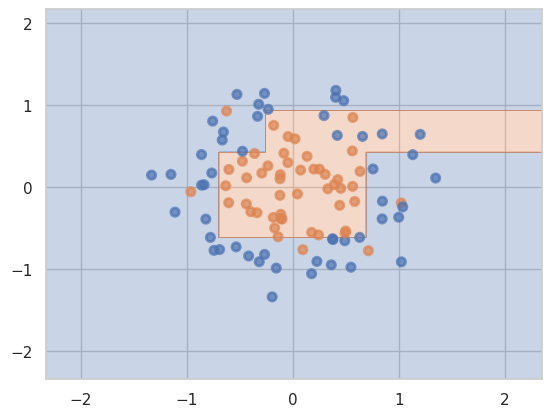

max_depth = None
min_leaf_samples = 7
Train accuracy: 0.835820895522388
Test accuracy: 0.9393939393939394



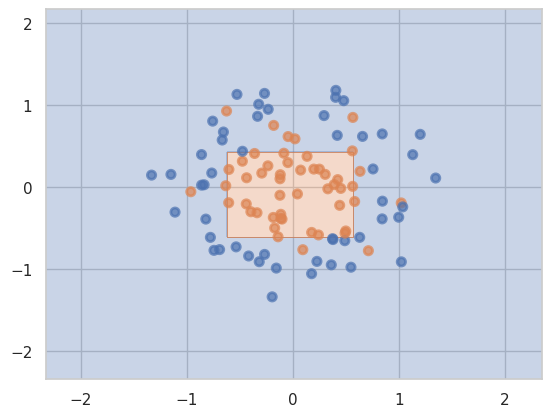

max_depth = 1
min_leaf_samples = 1
Train accuracy: 0.6716417910447762
Test accuracy: 0.6363636363636364



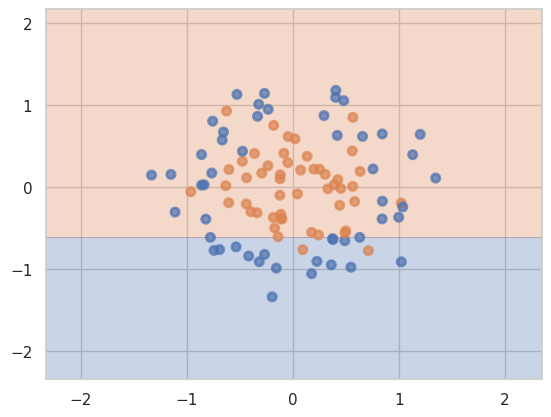

max_depth = 1
min_leaf_samples = 3
Train accuracy: 0.6716417910447762
Test accuracy: 0.6363636363636364



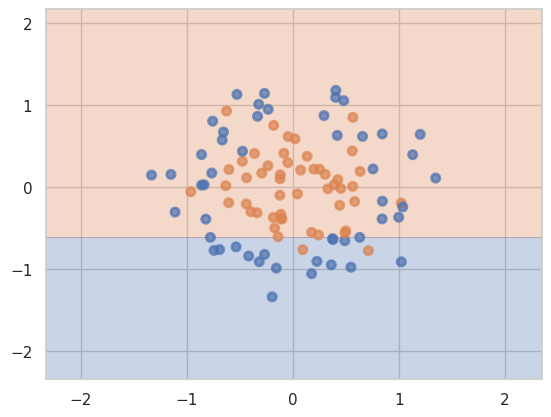

max_depth = 1
min_leaf_samples = 5
Train accuracy: 0.6716417910447762
Test accuracy: 0.6363636363636364



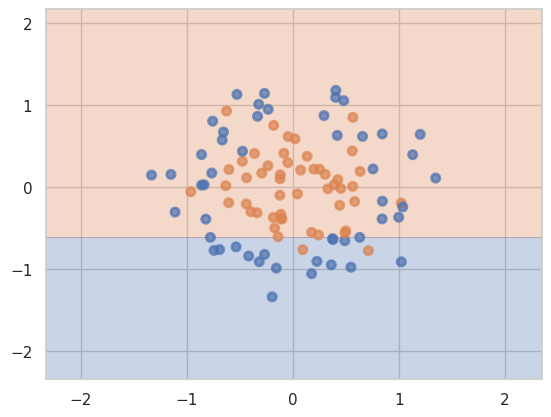

max_depth = 1
min_leaf_samples = 7
Train accuracy: 0.6716417910447762
Test accuracy: 0.6363636363636364



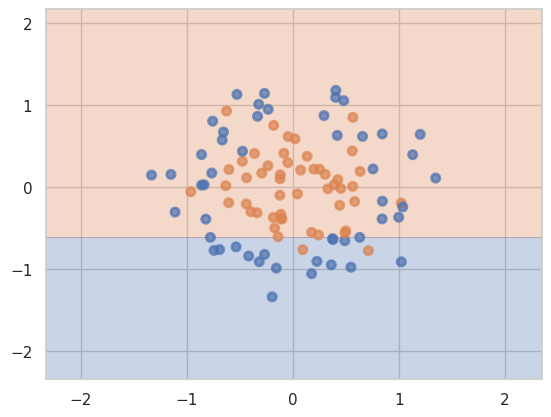

max_depth = 3
min_leaf_samples = 1
Train accuracy: 0.8507462686567164
Test accuracy: 0.8181818181818182



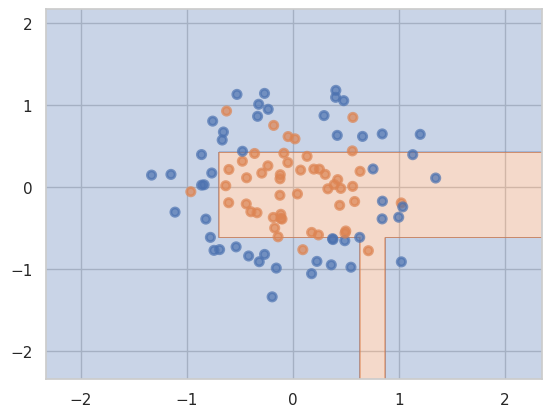

max_depth = 3
min_leaf_samples = 3
Train accuracy: 0.835820895522388
Test accuracy: 0.8484848484848485



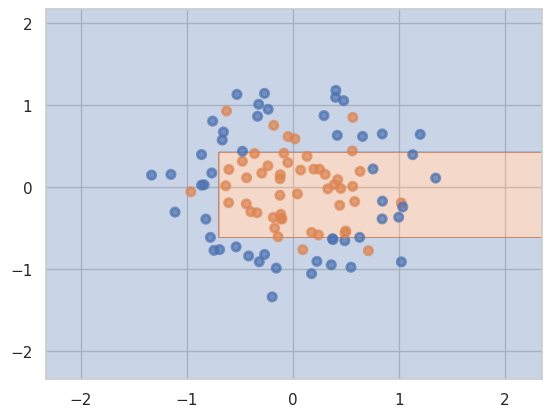

max_depth = 3
min_leaf_samples = 5
Train accuracy: 0.835820895522388
Test accuracy: 0.8484848484848485



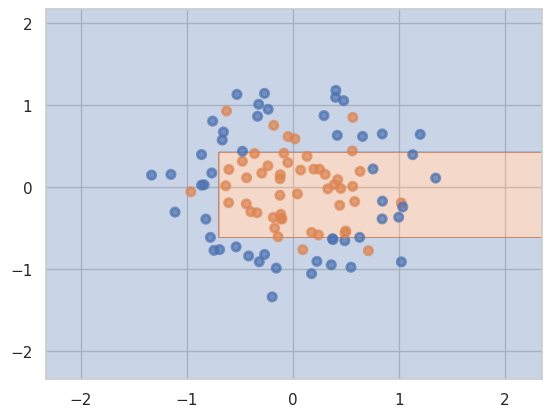

max_depth = 3
min_leaf_samples = 7
Train accuracy: 0.8208955223880597
Test accuracy: 0.8484848484848485



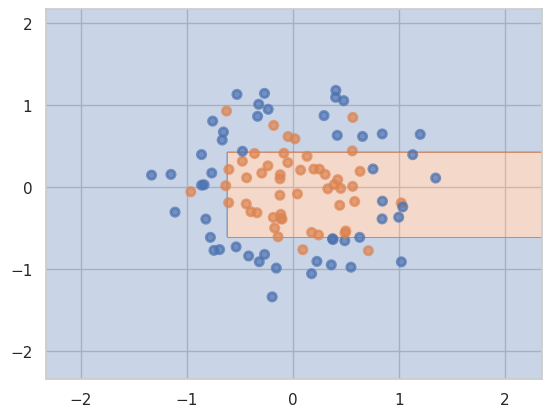

max_depth = 5
min_leaf_samples = 1
Train accuracy: 0.9701492537313433
Test accuracy: 0.8484848484848485



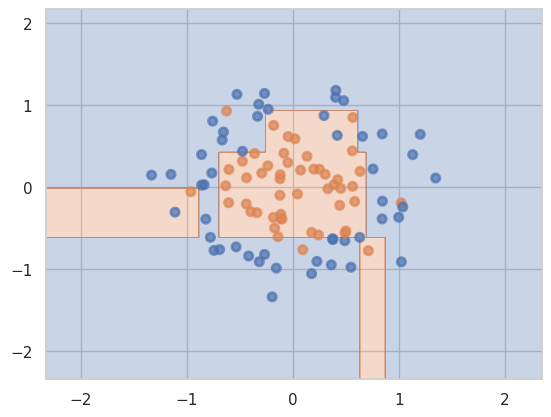

max_depth = 5
min_leaf_samples = 3
Train accuracy: 0.9402985074626866
Test accuracy: 0.9090909090909091



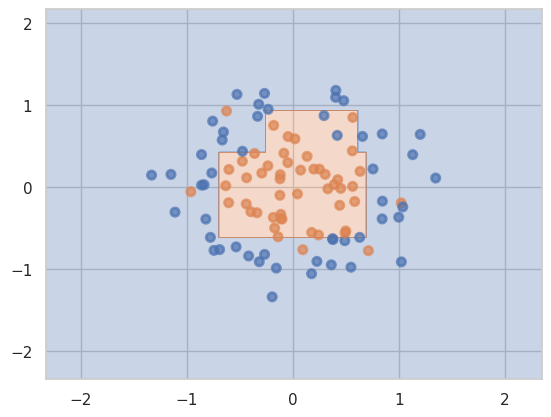

max_depth = 5
min_leaf_samples = 5
Train accuracy: 0.8955223880597015
Test accuracy: 0.9090909090909091



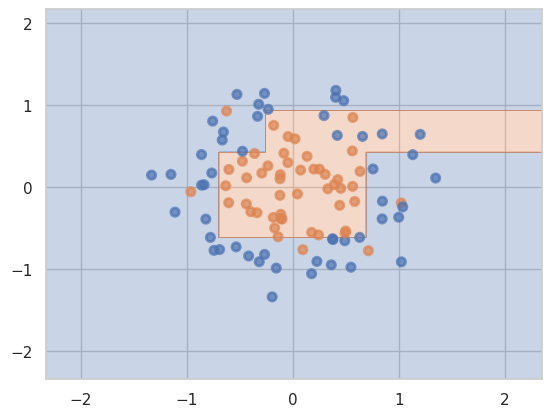

max_depth = 5
min_leaf_samples = 7
Train accuracy: 0.835820895522388
Test accuracy: 0.9393939393939394



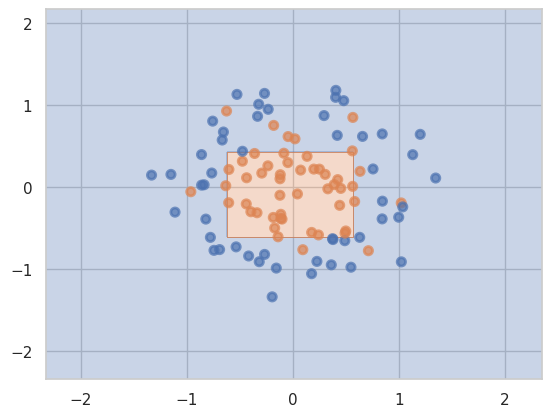

Moons
----------
max_depth = None
min_leaf_samples = 3
Train accuracy: 0.9701492537313433
Test accuracy: 0.9696969696969697



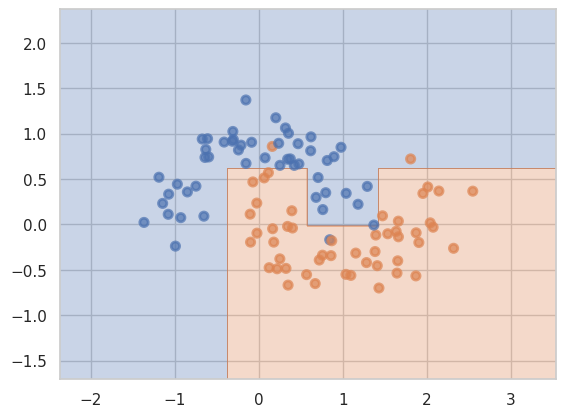

max_depth = None
min_leaf_samples = 5
Train accuracy: 0.9701492537313433
Test accuracy: 0.9696969696969697



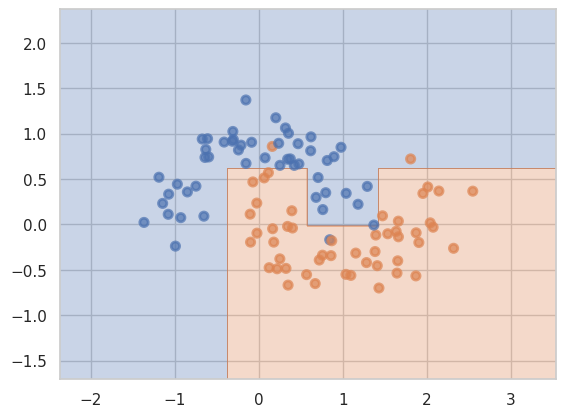

max_depth = None
min_leaf_samples = 7
Train accuracy: 0.8656716417910447
Test accuracy: 0.8484848484848485



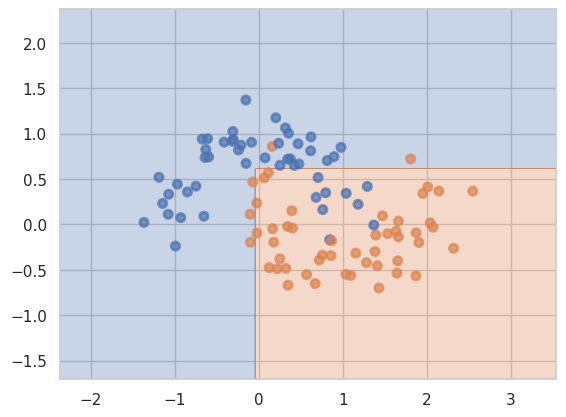

max_depth = 1
min_leaf_samples = 1
Train accuracy: 0.8208955223880597
Test accuracy: 0.696969696969697



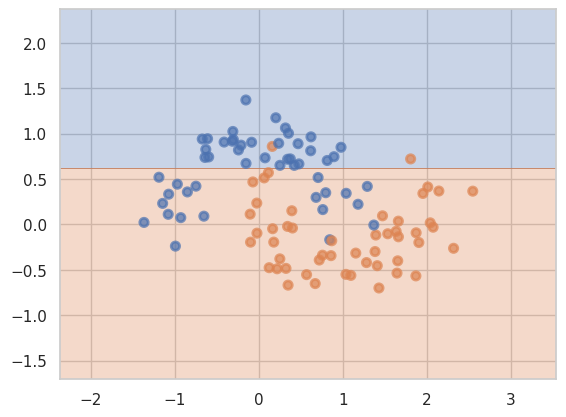

max_depth = 1
min_leaf_samples = 3
Train accuracy: 0.8208955223880597
Test accuracy: 0.696969696969697



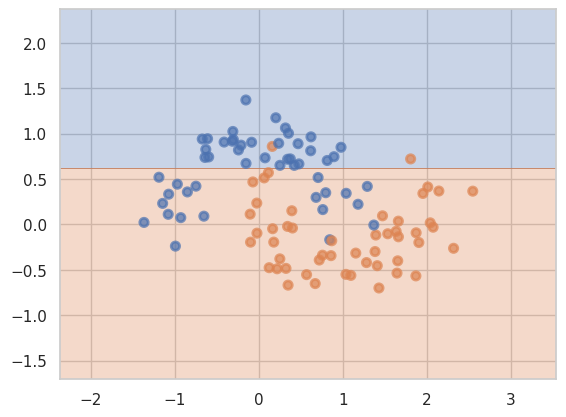

max_depth = 1
min_leaf_samples = 5
Train accuracy: 0.8208955223880597
Test accuracy: 0.696969696969697



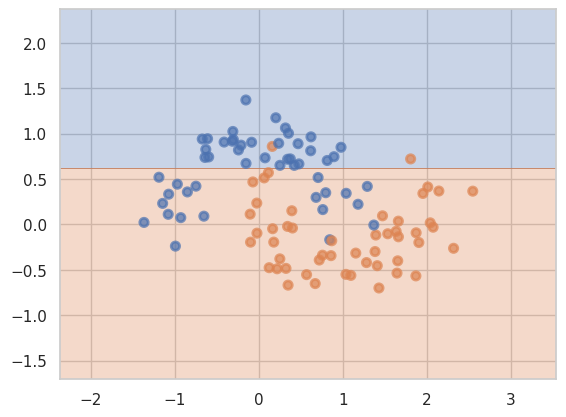

max_depth = 1
min_leaf_samples = 7
Train accuracy: 0.8208955223880597
Test accuracy: 0.696969696969697



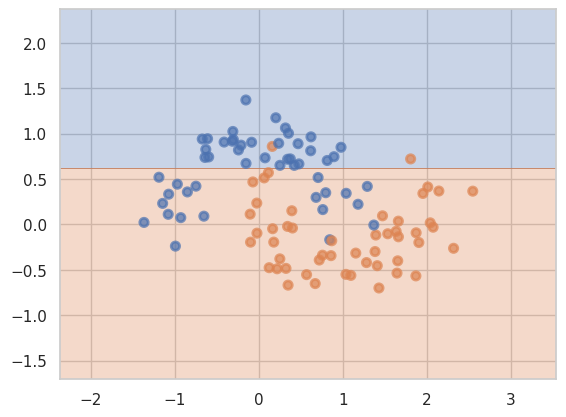

max_depth = 3
min_leaf_samples = 1
Train accuracy: 0.9104477611940298
Test accuracy: 0.8787878787878788



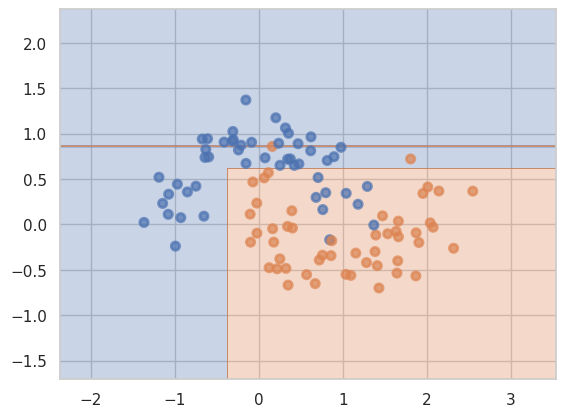

max_depth = 3
min_leaf_samples = 3
Train accuracy: 0.8955223880597015
Test accuracy: 0.8787878787878788



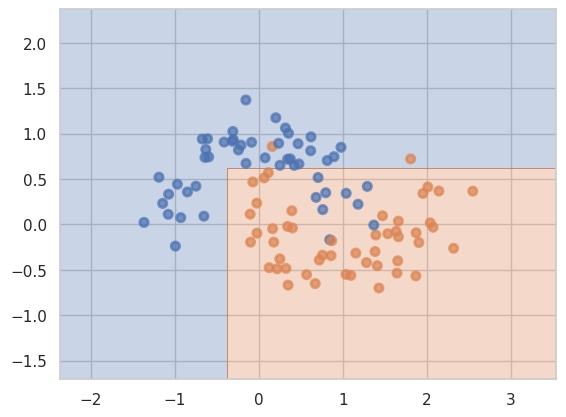

max_depth = 3
min_leaf_samples = 5
Train accuracy: 0.8955223880597015
Test accuracy: 0.8787878787878788



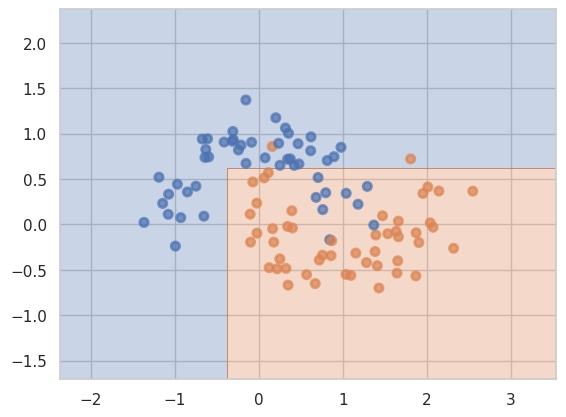

max_depth = 3
min_leaf_samples = 7
Train accuracy: 0.8656716417910447
Test accuracy: 0.8484848484848485



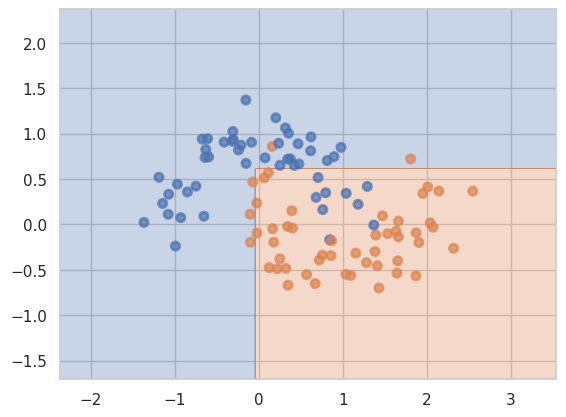

max_depth = 5
min_leaf_samples = 1
Train accuracy: 1.0
Test accuracy: 0.9696969696969697



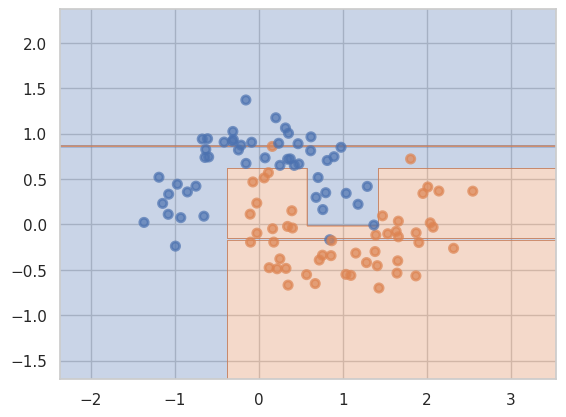

max_depth = 5
min_leaf_samples = 3
Train accuracy: 0.9701492537313433
Test accuracy: 0.9696969696969697



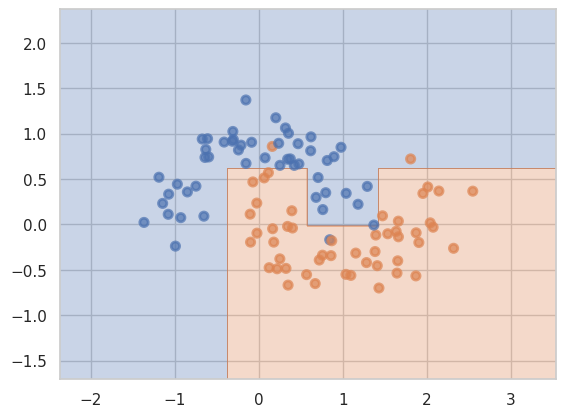

max_depth = 5
min_leaf_samples = 5
Train accuracy: 0.9701492537313433
Test accuracy: 0.9696969696969697



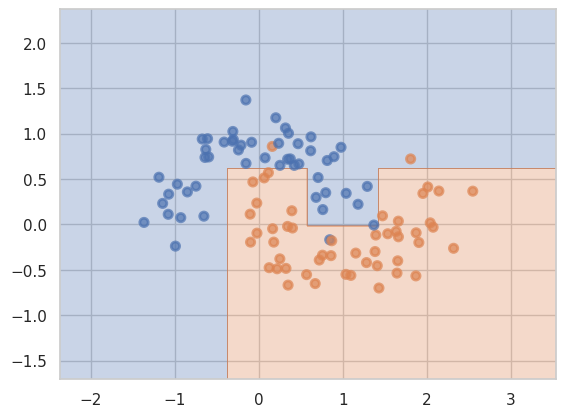

max_depth = 5
min_leaf_samples = 7
Train accuracy: 0.8656716417910447
Test accuracy: 0.8484848484848485



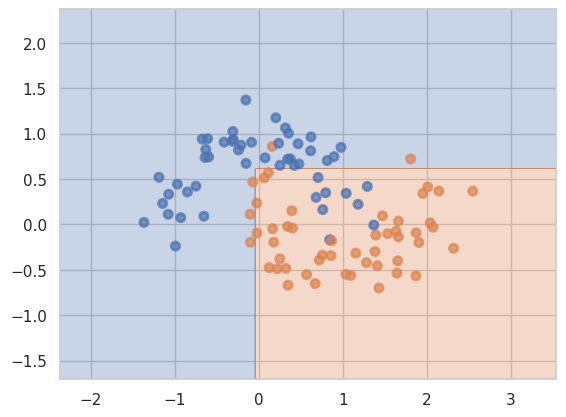

Classification
----------
max_depth = None
min_leaf_samples = 3
Train accuracy: 0.9104477611940298
Test accuracy: 0.7272727272727273



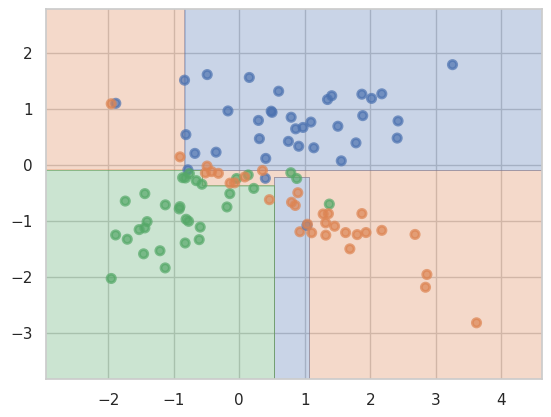

max_depth = None
min_leaf_samples = 5
Train accuracy: 0.8805970149253731
Test accuracy: 0.7575757575757576



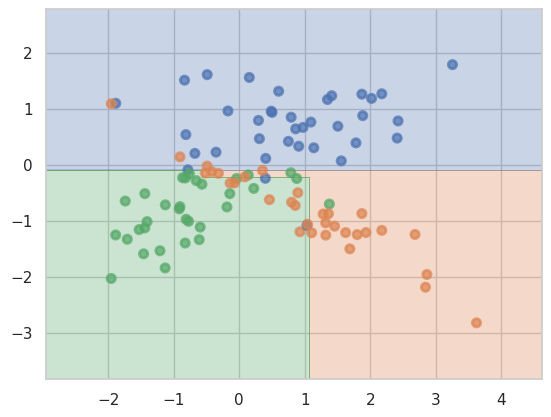

max_depth = None
min_leaf_samples = 7
Train accuracy: 0.8656716417910447
Test accuracy: 0.7575757575757576



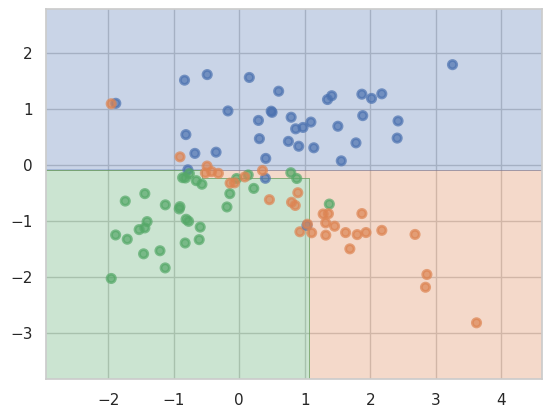

max_depth = 1
min_leaf_samples = 1
Train accuracy: 0.6567164179104478
Test accuracy: 0.6666666666666666



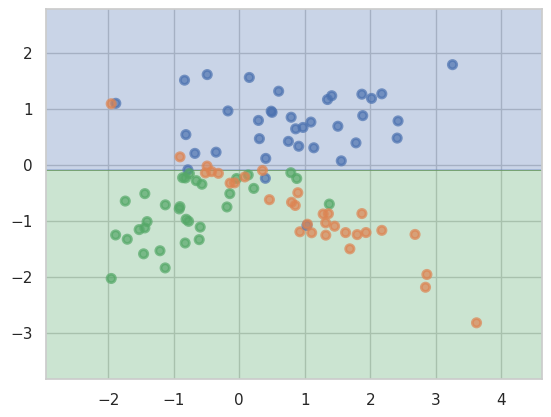

max_depth = 1
min_leaf_samples = 3
Train accuracy: 0.6567164179104478
Test accuracy: 0.6666666666666666



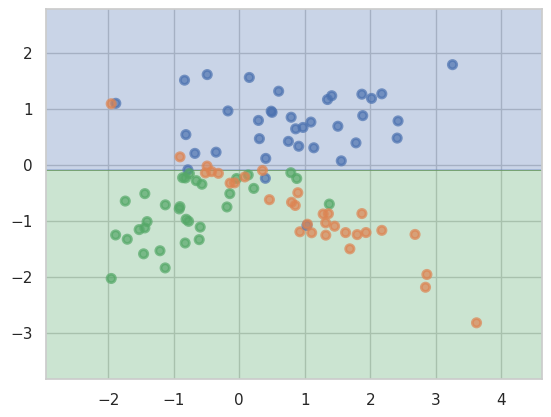

max_depth = 1
min_leaf_samples = 5
Train accuracy: 0.6567164179104478
Test accuracy: 0.6666666666666666



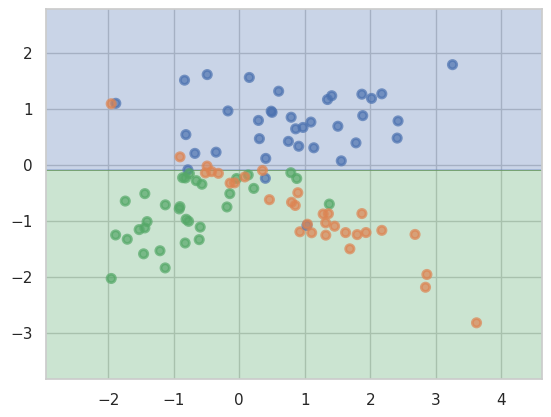

max_depth = 1
min_leaf_samples = 7
Train accuracy: 0.6567164179104478
Test accuracy: 0.6666666666666666



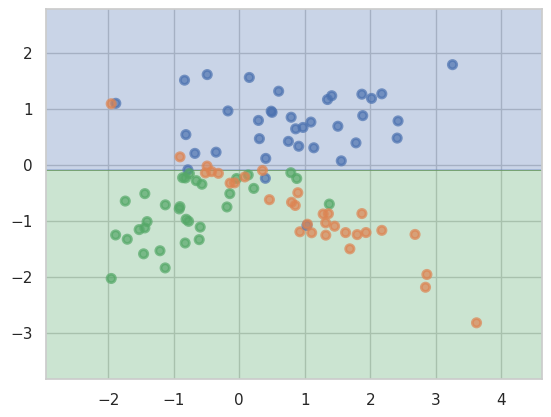

max_depth = 3
min_leaf_samples = 1
Train accuracy: 0.8805970149253731
Test accuracy: 0.8787878787878788



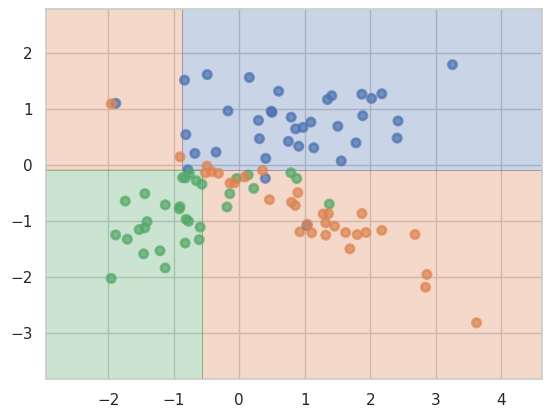

max_depth = 3
min_leaf_samples = 3
Train accuracy: 0.8656716417910447
Test accuracy: 0.8787878787878788



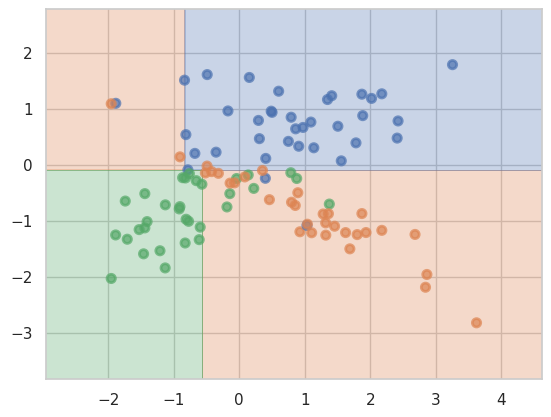

max_depth = 3
min_leaf_samples = 5
Train accuracy: 0.8507462686567164
Test accuracy: 0.9090909090909091



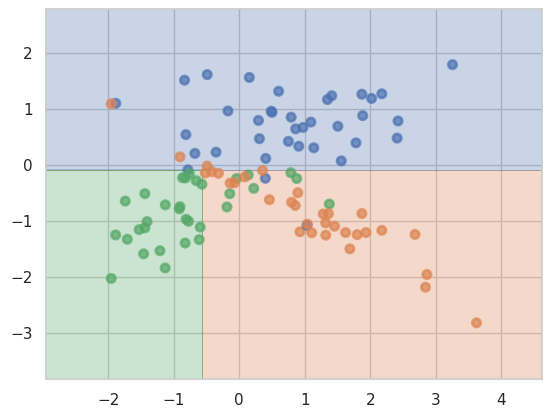

max_depth = 3
min_leaf_samples = 7
Train accuracy: 0.8507462686567164
Test accuracy: 0.9090909090909091



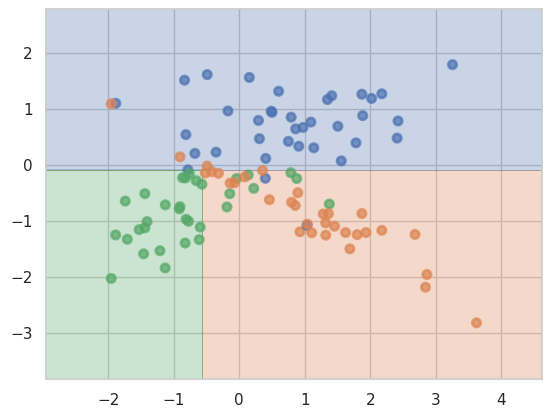

max_depth = 5
min_leaf_samples = 1
Train accuracy: 0.9552238805970149
Test accuracy: 0.7272727272727273



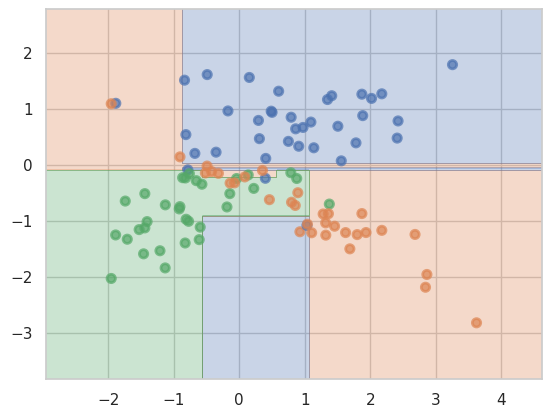

max_depth = 5
min_leaf_samples = 3
Train accuracy: 0.8955223880597015
Test accuracy: 0.7272727272727273



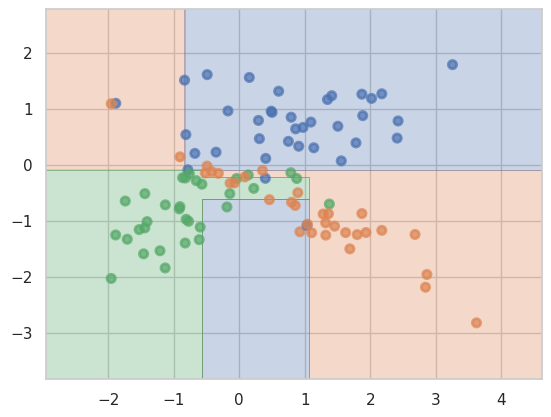

max_depth = 5
min_leaf_samples = 5
Train accuracy: 0.8805970149253731
Test accuracy: 0.7575757575757576



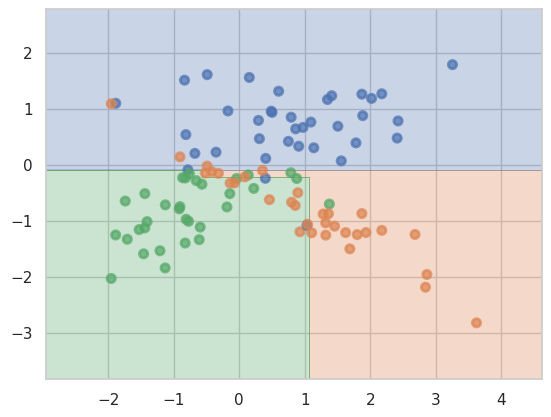

max_depth = 5
min_leaf_samples = 7
Train accuracy: 0.8656716417910447
Test accuracy: 0.7575757575757576



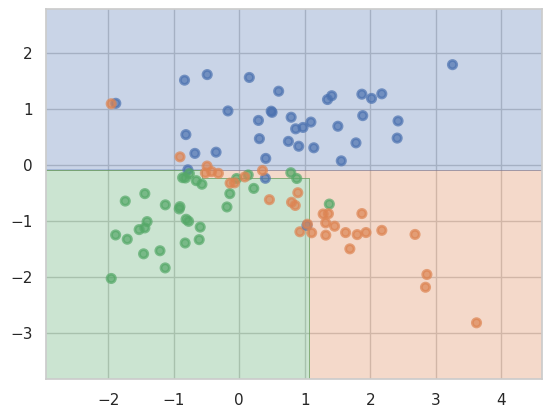

Circles
Best accuracy: 0.9393939393939394
Depth: None
Samples: 7

Moons
Best accuracy: 0.9696969696969697
Depth: None
Samples: 3

Classification
Best accuracy: 0.9090909090909091
Depth: 3
Samples: 5



In [8]:

### ╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ
depth = [None, 1, 3, 5]
samples = [1, 3, 5, 7]
final = []
from sklearn.metrics import accuracy_score
for i in range(3):
  X, y = datasets[i]
  S = train_test_split(X, y, test_size=0.33, random_state=9)
  Train, Test = [S[0], S[2]], [S[1], S[3]]
  best_acc = 0
  best_p = None
  print(dnames[i])
  print("-" * 10)
  for d in range(4):
    for s in range(4):
      if d == 0 and s == 0:
        continue
      print(f"max_depth = {depth[d]}")
      print(f"min_leaf_samples = {samples[s]}")
      clf = DecisionTreeClassifier(max_depth=depth[d],
                                   min_samples_leaf=samples[s])
      clf.fit(*Train)
      train_acc = accuracy_score(Train[1], clf.predict(Train[0]))
      test_acc = accuracy_score(Test[1], clf.predict(Test[0]))
      if test_acc > best_acc:
        best_acc = test_acc
        best_p = (depth[d], samples[s])
      print(f'Train accuracy: {train_acc}')
      print(f'Test accuracy: {test_acc}')
      print()
      plot_surface(clf, X, y)
      plt.show()
  final.append((f"{dnames[i]}\nBest accuracy: {best_acc}\nDepth: {best_p[0]}\nSamples: {best_p[1]}"))
for i in range(3):
  print(final[i])
  print()


__Ответ:__ Можно заметить, что излишнее обобщение происходит при относительно небольших значениях максимальной глубины и минимального числа семплов на лист. Такая закономерность наблюдается для всех датасетов. Это связано с тем, что при данных параметрах в дереве находится меньше узлов и листьев, чем при больших значениях перебранных параметров.

# 2. Решающие деревья своими руками

В этой части вам нужно реализовать свой класс для обучения решающего дерева в задаче бинарной классификации с возможностью обработки вещественных и категориальных признаков.

__Задание 3. (1.5 балл)__

Реализуйте функцию find_best_split из модуля hw2code.py

__Задание 4. (0.5 балла)__

Загрузите таблицу students.csv (это немного преобразованный датасет [User Knowledge](https://archive.ics.uci.edu/ml/datasets/User+Knowledge+Modeling)). В ней признаки объекта записаны в первых пяти столбцах, а в последнем записана целевая переменная (класс: 0 или 1). Постройте на одном изображении пять кривых "порог — значение критерия Джини" для всех пяти признаков. Отдельно визуализируйте scatter-графики "значение признака — класс" для всех пяти признаков.

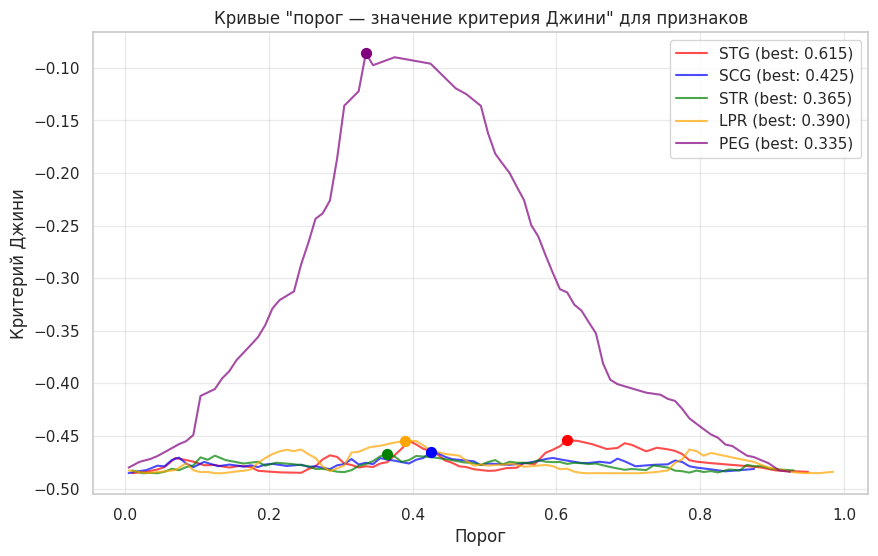

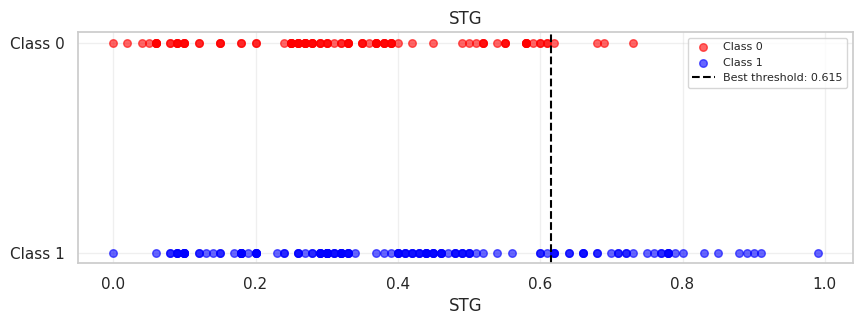

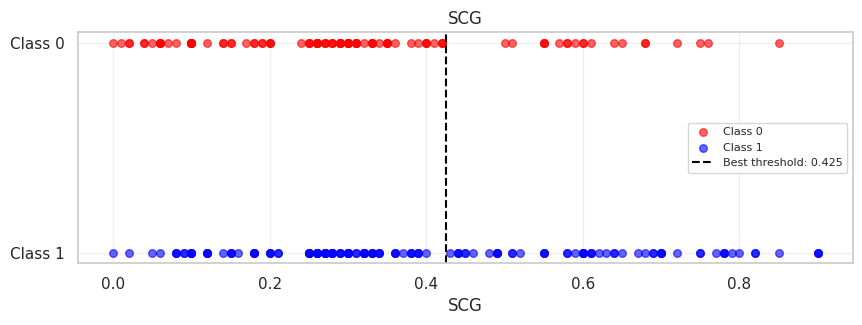

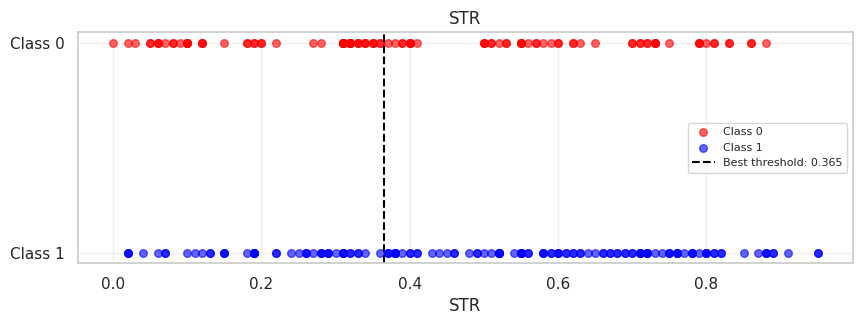

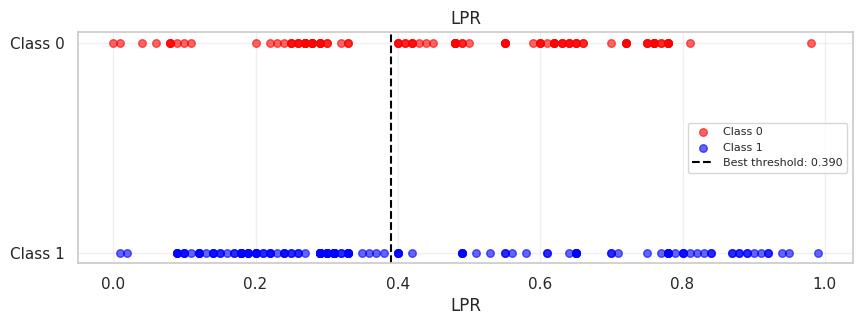

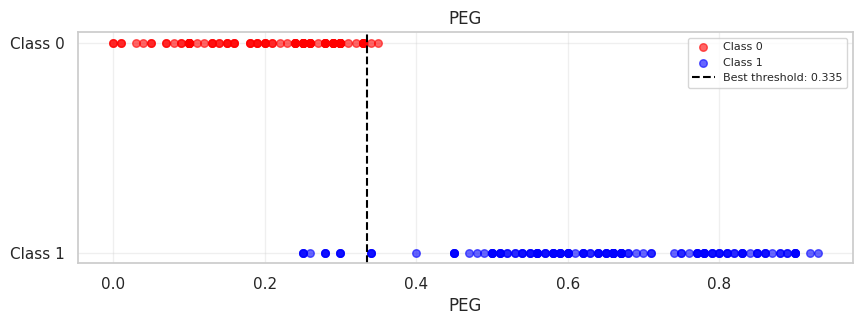

In [9]:
### ╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ
from hw2code import find_best_split

df = pd.read_csv('datasets/students.csv')


features = df.iloc[:, :-1]  
target = df.iloc[:, -1]     


fig, axes = plt.subplots(1, figsize=(10, 6))



colors = ['red', 'blue', 'green', 'orange', 'purple']
feature_names = features.columns

vals = []

for i, feature_name in enumerate(feature_names):
    feature_vector = features[feature_name].values
    target_vector = target.values
    
    thresholds, ginis, best_threshold, best_gini = find_best_split(feature_vector, target_vector)
    vals.append([thresholds, ginis, best_threshold, best_gini])

for i, feature_name in enumerate(feature_names):
    feature_vector = features[feature_name].values
    target_vector = target.values
    
    thresholds, ginis, best_threshold, best_gini = vals[i]
    
    if len(thresholds) > 0:
        axes.plot(thresholds, ginis, 
                    color=colors[i], 
                    label=f'{feature_name} (best: {best_threshold:.3f})',
                    alpha=0.7)
        axes.scatter(best_threshold, best_gini, 
                       color=colors[i], 
                       s=50, zorder=5)

axes.set_xlabel('Порог')
axes.set_ylabel('Критерий Джини')
axes.set_title('Кривые "порог — значение критерия Джини" для признаков')
axes.legend()
axes.grid(True, alpha=0.4)
plt.show()

for i, feature_name in enumerate(feature_names):
    feature_vector = features[feature_name].values
    

    fig, ax = plt.subplots(1, figsize=(10, 3))
    
    class_0 = feature_vector[target == 0]
    class_1 = feature_vector[target == 1]
    
    ax.scatter(class_0, np.zeros_like(class_0) + 0.1, 
              color='red', alpha=0.6, label='Class 0', s=30)
    ax.scatter(class_1, np.zeros_like(class_1) - 0.1, 
              color='blue', alpha=0.6, label='Class 1', s=30)
    
    thresholds, ginis, best_threshold, best_gini = vals[i]
    if best_threshold is not None:
        ax.axvline(x=best_threshold, color='black', linestyle='--', 
                  label=f'Best threshold: {best_threshold:.3f}')
    
    ax.set_xlabel(f'{feature_name}')
    ax.set_yticks([-0.1, 0.1])
    ax.set_yticklabels(['Class 1', 'Class 0'])
    ax.set_title(f'{feature_name}')
    ax.legend(fontsize=8)
    ax.grid(True, alpha=0.3)
    plt.show()


__Задание 5. (0.5 балла)__

Исходя из кривых значений критерия Джини, по какому признаку нужно производить деление выборки на два поддерева? Согласуется ли этот результат с визуальной оценкой scatter-графиков? Как бы охарактеризовали вид кривой для "хороших" признаков, по которым выборка делится почти идеально? Чем отличаются кривые для признаков, по которым деление практически невозможно?

**Ответ:** Деление выборки можно производить по параметру PEG (наибольшее значение критерия, результат согласуется с визуальным представлением). Кривые хороших признаков лежат выше,более крутые и имеют явные пики, по которым можно суить о наилучших порогах. Кривые неподходящих признков находятся ниже, менее крутые.

__Задание 6. (1.5 балла).__

Разберитесь с уже написанным кодом в классе DecisionTree модуля hw2code.py. Найдите ошибки в реализации метода \_fit_node. Напишите функцию \_predict_node.

 Построение дерева осуществляется согласно базовому жадному алгоритму, предложенному в лекции. Выбор лучшего разбиения необходимо производить по критерию Джини. Критерий останова: все объекты в листе относятся к одному классу или ни по одному признаку нельзя разбить выборку. Ответ в листе: наиболее часто встречающийся класс в листе. Для категориальных признаков выполняется преобразование, описанное в лекции в разделе «Учет категориальных признаков».

__Задание 7. (0.5 балла)__

Протестируйте свое решающее дерево на датасете [mushrooms](https://archive.ics.uci.edu/ml/datasets/Mushroom). Вам нужно скачать таблицу agaricus-lepiota.data (лежит на гитхабе вместе с заданием), прочитать ее с помощью pandas, применить к каждому столбцу LabelEncoder (из sklearn), чтобы преобразовать строковые имена категорий в натуральные числа. Первый столбец — это целевая переменная (e — edible, p — poisonous) Мы будем измерять качество с помощью accuracy, так что нам не очень важно, что будет классом 1, а что — классом 0. Обучите решающее дерево на половине случайно выбранных объектов (признаки в датасете категориальные) и сделайте предсказания для оставшейся половины. Вычислите accuracy.

У вас должно получиться значение accuracy, равное единице (или очень близкое к единице), и не очень глубокое дерево.

In [10]:
### ╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ
from sklearn.preprocessing import LabelEncoder
from hw2code import DecisionTree

def tree_depth(node):
    if node["type"] == "terminal":
        return 0
    l  = tree_depth(node["left_child"])
    r= tree_depth(node["right_child"])
    return 1 + max(l, r)

df = pd.read_csv("./datasets/agaricus-lepiota.data", header=None)

encoders = {}
for col in df.columns:
    t = LabelEncoder()
    df[col] = t.fit_transform(df[col])
    encoders[col] = t

X = df.iloc[:, 1:].values
y = df.iloc[:, 0].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=9)

feature_types = ["categorical"] * X.shape[1]
tree = DecisionTree(feature_types)
tree.fit(X_train, y_train)

prediction = tree.predict(X_test)
acc = accuracy_score(y_test, prediction)
depth = tree_depth(tree._tree)

print(f"Accuracy: {acc:.3f}")
print(f"Depth: {depth}")

Accuracy: 1.000
Depth: 6


__Задание 8. (бонус, 1 балл)__

Реализуйте в классе DecisionTree поддержку параметров max_depth, min_samples_split и min_samples_leaf по аналогии с DecisionTreeClassifier. Постройте графики зависимости качества предсказания в зависимости от этих параметров для набора данных tic-tac-toe (см. следующий пункт).

In [11]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer
scorer = make_scorer(accuracy_score)

df = pd.read_csv("./datasets/tic-tac-toe-endgame.csv", header=None)
X = df.iloc[:, :-1].apply(LabelEncoder().fit_transform).values
y = LabelEncoder().fit_transform(df.iloc[:, -1].values)

samples = [2, 5, 10, 15]

tres = []

for i in samples:
    for j in samples:
        for k in samples:
            tree = DecisionTree(feature_types, max_depth=i,
                                min_samples_split=j, min_samples_leaf=k)
            scores = cross_val_score(tree, X, y,
                                     cv=10, scoring='accuracy')
            tres.append([i, j, k, scores.mean()])




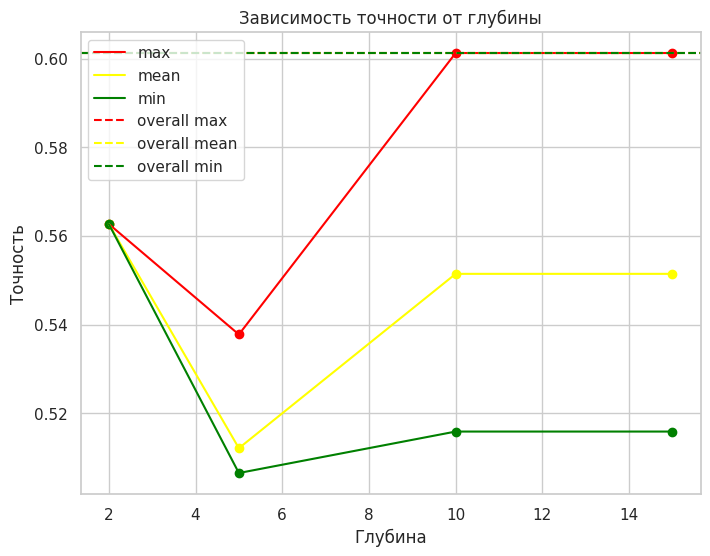

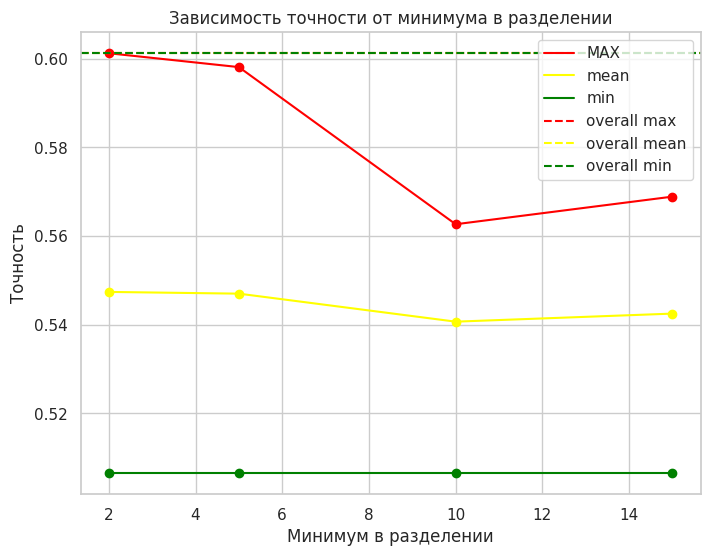

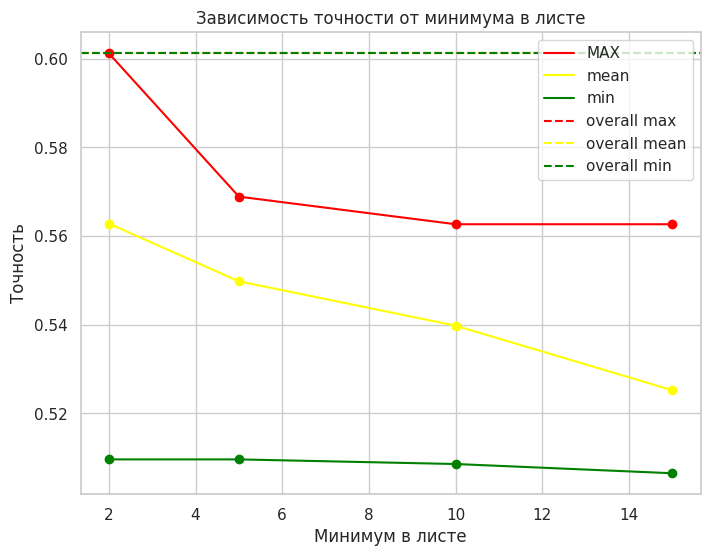

In [19]:
res = pd.DataFrame(tres, columns=["md", "mss", "msl", "acc"])

ame = res["acc"].mean()
amx = res["acc"].max()
amn = res["acc"].min()

mx = []
me = []
mn = []
plt.figure(figsize=(8,6))
for md in samples:
    vals = res[res["md"] == md]["acc"]
    mx.append(vals.max())
    me.append(vals.mean())
    mn.append(vals.min())
plt.plot(samples, mx, c="red", label="max")
plt.plot(samples, me, c="yellow", label="mean")
plt.plot(samples, mn, c="green", label="min")
plt.scatter(samples, mx, c="red")
plt.scatter(samples, me, c="yellow")
plt.scatter(samples, mn, c="green")
plt.axhline(amx, c="red", label="overall max", linestyle="--")
plt.axhline(amx, c="yellow", label="overall mean", linestyle="--")
plt.axhline(amx, c="green", label="overall min", linestyle="--")
plt.xlabel("Глубина")
plt.ylabel("Точность")
plt.title("Зависимость точности от глубины")
plt.grid(True)
plt.legend()
plt.show()
mn.clear()
me.clear()
mx.clear()

plt.figure(figsize=(8,6))
for mss in samples:
    vals = res[res["mss"] == mss]["acc"]
    mx.append(vals.max())
    me.append(vals.mean())
    mn.append(vals.min())
plt.plot(samples, mx, c="red", label="MAX")
plt.plot(samples, me, c="yellow", label="mean")
plt.plot(samples, mn, c="green", label="min")
plt.scatter(samples, mx, c="red")
plt.scatter(samples, me, c="yellow")
plt.scatter(samples, mn, c="green")
plt.axhline(amx, c="red", label="overall max", linestyle="--")
plt.axhline(amx, c="yellow", label="overall mean", linestyle="--")
plt.axhline(amx, c="green", label="overall min", linestyle="--")
plt.xlabel("Минимум в разделении")
plt.ylabel("Точность")
plt.title("Зависимость точности от минимума в разделении")
plt.grid(True)
plt.legend()
plt.show()
mn.clear()
me.clear()
mx.clear()

plt.figure(figsize=(8,6))
for msl in samples:
    vals = res[res["msl"] == msl]["acc"]
    mx.append(vals.max())
    me.append(vals.mean())
    mn.append(vals.min())
plt.plot(samples, mx, c="red", label="MAX")
plt.plot(samples, me, c="yellow", label="mean")
plt.plot(samples, mn, c="green", label="min")
plt.scatter(samples, mx, c="red")
plt.scatter(samples, me, c="yellow")
plt.scatter(samples, mn, c="green")
plt.axhline(amx, c="red", label="overall max", linestyle="--")
plt.axhline(amx, c="yellow", label="overall mean", linestyle="--")
plt.axhline(amx, c="green", label="overall min", linestyle="--")
plt.xlabel("Минимум в листе")
plt.ylabel("Точность")
plt.title("Зависимость точности от минимума в листе")
plt.grid(True)
plt.legend()
plt.show()
mn.clear()
me.clear()
mx.clear()


__Задание 9. (2 балла)__

Загрузите следующие наборы данных (напомним, что pandas умеет загружать файлы по url, в нашем случае это файл \*.data), предварительно ознакомившись с описанием признаков и целевой переменной в каждом из них (она записаны в Data Folder, в файле *.names):
* [mushrooms](https://archive.ics.uci.edu/ml/datasets/Mushroom) (загрузили в предыдущем пункте, классы записаны в нулевом столбце)
* [tic-tac-toe](https://archive.ics.uci.edu/ml/datasets/Tic-Tac-Toe+Endgame) (классы записаны в последнем столбце, датасет лежит на гитхабе вместе с заданием)
* [cars](https://archive.ics.uci.edu/ml/datasets/Car+Evaluation) (классы записаны в последнем столбце, считаем что unacc, acc — это класс 0, good, vgood — класс 1)
* [nursery](https://archive.ics.uci.edu/ml/datasets/Nursery) (классы записаны в последнем столбце, считаем, что not_recom и recommend — класс 0, very_recom, priority, spec_prior — класс 1).

Закодируйте категориальные признаки, использовав LabelEncoder. С помощью cross_val_score (cv=10) оцените accuracy на каждом из этих наборов данных следующих алгоритмов:
* DecisionTree, считающий все признаки вещественными
* DecisionTree, считающий все признаки категориальными
* DecisionTree, считающий все признаки вещественными + one-hot-encoding всех признаков
* DecisionTreeClassifier из sklearn. Запишите результат в pd.DataFrame (по строкам — наборы данных, по столбцам — алгоритмы).

Рекомендации:
* Чтобы cross_val_score вычисляла точность, нужно передать scoring=make_scorer(accuracy_score), обе фукнции из sklearn.metrics.
* Если вам позволяет память (а она скорее всего позволяет), указывайте параметр sparse=False в OneHotEncoder (если вы, конечно, используете его). Иначе вам придется добиваться того, чтобы ваша реализация дерева умела работать с разреженными матрицами (что тоже, в целом, не очень сложно).

In [13]:
### ╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer

data = {}

df = pd.read_csv("./datasets/agaricus-lepiota.data", header=None)
for col in df.columns:
    df[col] = LabelEncoder().fit_transform(df[col])
X = df.iloc[:, 1:].values
y = df.iloc[:, 0].values
data["mushrooms"] = (X, y)

df = pd.read_csv("./datasets/tic-tac-toe-endgame.csv", header=None)
X = df.iloc[:, :-1].apply(LabelEncoder().fit_transform).values
y = LabelEncoder().fit_transform(df.iloc[:, -1].values)
data["tic-tac-toe"] = (X, y)

cols = ["buying", "maint", "doors", "persons", "lug_boot", "safety", "class"]
df = pd.read_csv(
    "https://archive.ics.uci.edu/ml/machine-learning-databases/car/car.data", 
    names=cols
)
df["class"] = df["class"].map(lambda v: 1 if v in ("good", "vgood") else 0)
X = df.iloc[:, :-1].apply(LabelEncoder().fit_transform).values
y = df["class"].values
data["cars"] = (X, y)

cols = ["parents", "has_nurs", "form", "children", "housing",
        "finance", "social", "health", "class"]
df = pd.read_csv(
    "https://archive.ics.uci.edu/ml/machine-learning-databases/nursery/nursery.data",
    names=cols
)
df["class"] = df["class"].map(lambda v: 0 if v in ("not_recom", "recommend") else 1)
X = df.iloc[:, :-1].apply(LabelEncoder().fit_transform).values
y = df["class"].values
data["nursery"] = (X, y)

scorer = make_scorer(accuracy_score)

def get_treee(X):
    n= X.shape[1]
    OHE =  OneHotEncoder(sparse_output=False).fit_transform(X)
    trees = {
        "real": [DecisionTree(["real"] * n), X],
        "categorical": [DecisionTree(["categorical"] * n), X],
        "OHE": [DecisionTree(["real"] * OneHotEncoder(sparse_output=False).fit_transform(X).shape[1]), OHE],
        "DecisionTreeClassifier": [DecisionTreeClassifier(random_state=42), X]
    }
    return trees


res = []
for name, (X, y) in data.items():
    trees = get_treee(X)
    for tname, tree in trees.items():
        scores = cross_val_score(tree[0], tree[1], y, cv=10, scoring=scorer)
        res.append([name, tname, scores.mean()])


In [14]:
df = pd.DataFrame(res, columns=['Dataset', 'Tree', 'Accuracy'])
result_table = df.pivot(index='Dataset', columns='Tree', values='Accuracy')

print(result_table)

Tree         DecisionTreeClassifier       OHE  categorical      real
Dataset                                                             
cars                       0.942707  0.919495     0.967546  0.942647
mushrooms                  0.960384  0.999631     1.000000  0.999261
nursery                    0.999691  0.999537     0.999537  0.999691
tic-tac-toe                0.785351  0.574167     0.607511  0.497083


__Задание 10. (1 балла)__

Проанализируйте результаты эксперимента.
Одинаково ли для разных наборов данных ранжируются алгоритмы?
Порассуждайте, почему так происходит.

Обратите внимание на значение признаков в разных наборах данных.
Присутствует ли в результатах какая-то компонента случайности?
Можно ли повлиять на нее и улушить работу алгоритмов?

**Ответ:** Алгоритмы ранжируются по разному для разных наборов данных. Решающие деревья (категориальные) показали наилучшие результаты для обработки классификации чисто категориальных данных (mooshrooms, cars) и сложных нелинейных зависимостей (XO). 

Компонента случайности в результатах присутствует, она связана с кросс-валидацией (обучения и проверка проводится на отобранных случайных частях сета). Зафиксировав random_state, можно избавится от элемента слуайности в разбиениях. Улучшить результаты возможно посредством подбора гиперпараметров.

Вставьте что угодно, описывающее ваши впечатления от этого задания:

![увы](https://external-content.duckduckgo.com/iu/?u=https%3A%2F%2Ftse2.explicit.bing.net%2Fth%2Fid%2FOIP.zmF_6gfGYWAQa5DPtel0TgHaHL%3Fpid%3DApi&f=1&ipt=e1a4efe1a35f7d7ebbf7f1688853fe0fb1e77dc8136b0efcc0f2876885f7b72d&ipo=images)